In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

# Path to the ZIP file
zip_path = "/content/drive/MyDrive/dataset_crossvit/My First Project.v2i.coco.zip"

# Path to extract the dataset
extract_to = "/content/drive/MyDrive/dataset_crossvit/extracted"

# Function to extract the ZIP file
def extract_zip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted ZIP file to {extract_to}")

# Execute extraction
extract_zip(zip_path, extract_to)


Extracted ZIP file to /content/drive/MyDrive/dataset_crossvit/extracted


In [ ]:
print(os.listdir(extract_to))


['README.dataset.txt', 'README.roboflow.txt', 'train', 'valid']


### Load Dataset

In [ ]:
import os
import json
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import timm
from torch import nn, optim
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from PIL import Image
import matplotlib.pyplot as plt

train_dir = '/content/drive/MyDrive/dataset_crossvit/extracted/train'
valid_dir = '/content/drive/MyDrive/dataset_crossvit/extracted/valid'


### Define transformations

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),          # CrossViT input size
    transforms.ToTensor(),                  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])


In [ ]:
class RoboflowCocoDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        """
        Args:
            root_dir (str): Directory with all the images.
            annotation_file (str): Path to the COCO JSON annotation file.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        # Load COCO annotations
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)

        # Map category IDs to class indices
        self.category_map = {cat['id']: idx for idx, cat in enumerate(self.coco_data['categories'])}
        self.class_names = [cat['name'] for cat in self.coco_data['categories']]

        # Map image IDs to file names
        self.image_info = {img['id']: img['file_name'] for img in self.coco_data['images']}

        # Map image IDs to labels, filtering out images without annotations
        self.annotations = {}
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann['category_id'])

        # Filter images that have annotations
        self.valid_image_ids = [img_id for img_id in self.image_info.keys() if img_id in self.annotations]
        print(f"Total images: {len(self.image_info)}, Images with annotations: {len(self.valid_image_ids)}")

        # Debug: Print missing annotations
        missing = set(self.image_info.keys()) - set(self.annotations.keys())
        if missing:
            print(f"Images missing annotations: {len(missing)}. Example IDs: {list(missing)[:5]}")

    def __len__(self):
        return len(self.valid_image_ids)

    def __getitem__(self, idx):
        img_id = self.valid_image_ids[idx]
        img_path = os.path.join(self.root_dir, self.image_info[img_id])
        image = Image.open(img_path).convert('RGB')

        # Get label (first annotation)
        category_id = self.annotations[img_id][0]  # Safe now since we filtered
        label = self.category_map[category_id]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Load datasets
train_annotation_file = os.path.join(train_dir, '_annotations.coco.json')
valid_annotation_file = os.path.join(valid_dir, '_annotations.coco.json')

train_dataset = RoboflowCocoDataset(train_dir, train_annotation_file, transform=transform)
valid_dataset = RoboflowCocoDataset(valid_dir, valid_annotation_file, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print dataset info
print("Classes:", train_dataset.class_names)
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(valid_dataset)}")


Total images: 1176, Images with annotations: 1170
Images missing annotations: 6. Example IDs: [73, 747, 785, 537, 1019]
Total images: 289, Images with annotations: 288
Images missing annotations: 1. Example IDs: [52]
Classes: ['flag-and-pole', 'Ascending Triangle', 'Cup and Handle', 'Descending Triangle', 'Double Bottom', 'Double Top', 'Falling Wedge', 'Head and Shoulder', 'Inverse Head and Shoulder', 'Symmetric Triangle', 'Triple Bottom Reversal', 'flag-and-pole']
Training samples: 1170, Validation samples: 288


### Model Initialization

In [ ]:
num_classes = len(train_dataset.class_names)
model = timm.create_model('crossvit_15_240', pretrained=True, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("Model loaded on:", device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

Model loaded on: cuda


### Training Function

In [ ]:
def train_and_evaluate(model, train_loader, valid_loader, num_epochs=100, lr=0.003):
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = CrossEntropyLoss()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        train_loss /= len(train_loader.dataset)
        train_acc = correct_train / total_train

        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
        val_loss /= len(valid_loader.dataset)
        val_acc = correct_val / total_val

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history


In [ ]:
# Train and Evaluate
history = train_and_evaluate(model, train_loader, valid_loader, num_epochs=100)


Epoch 1/100, Train Loss: 2.1121, Train Acc: 0.2650, Val Loss: 2.1027, Val Acc: 0.2674
Epoch 2/100, Train Loss: 2.0476, Train Acc: 0.2761, Val Loss: 2.0359, Val Acc: 0.2674
Epoch 3/100, Train Loss: 2.0457, Train Acc: 0.2838, Val Loss: 2.0285, Val Acc: 0.2674
Epoch 4/100, Train Loss: 2.0408, Train Acc: 0.2838, Val Loss: 2.0294, Val Acc: 0.2674
Epoch 5/100, Train Loss: 2.0323, Train Acc: 0.2838, Val Loss: 2.0370, Val Acc: 0.2674
Epoch 6/100, Train Loss: 2.0310, Train Acc: 0.2838, Val Loss: 2.0303, Val Acc: 0.2674
Epoch 7/100, Train Loss: 2.0386, Train Acc: 0.2795, Val Loss: 2.0301, Val Acc: 0.2674
Epoch 8/100, Train Loss: 2.0302, Train Acc: 0.2838, Val Loss: 2.0276, Val Acc: 0.2674
Epoch 9/100, Train Loss: 2.0334, Train Acc: 0.2838, Val Loss: 2.0302, Val Acc: 0.2674
Epoch 10/100, Train Loss: 2.0230, Train Acc: 0.2838, Val Loss: 2.0523, Val Acc: 0.2674
Epoch 11/100, Train Loss: 2.0354, Train Acc: 0.2838, Val Loss: 2.0383, Val Acc: 0.2674
Epoch 12/100, Train Loss: 2.0249, Train Acc: 0.2838,


Baseline Validation Performance:
Final Validation Accuracy: 0.2674
Final Validation Loss: 2.0245


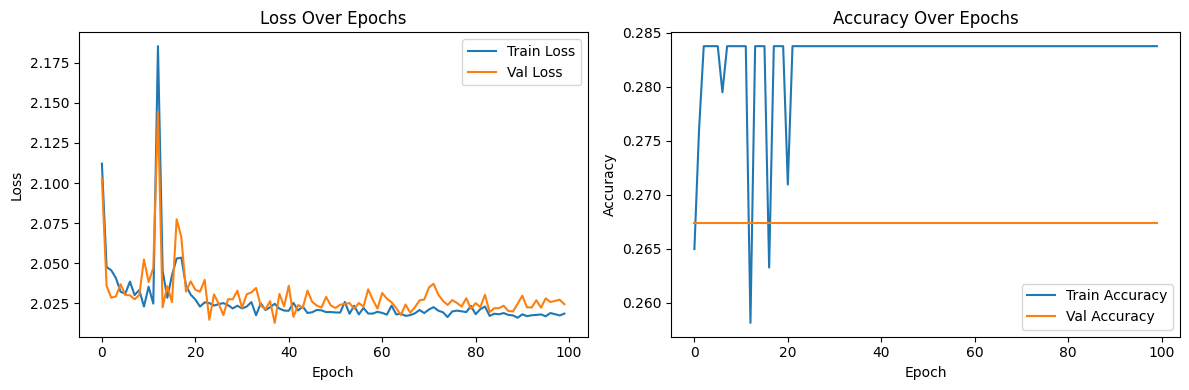

In [ ]:
# Baseline Results
print(f"\nBaseline Validation Performance:")
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")

# Plot Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()